# Multi-species Genomic Synthesis: Applying Natural Language Processing and Large Language Models (LLM) Techniques to DNA Sequencing

This project aims to develop a generic solution for synthesizing DNA sequences using techniques inspired by large language models (LLMs). The solution is not limited to genome data but can be extended to other contexts, such as synthesizing molecules. <br>
The project involves dealing with large amounts of "text", where the sequences are letter arrangements from an alphabet consisting of five symbols : **A, C, G, T** representing the four nucleotide bases Adenine, Cytosine, Guanine, Thymine and **'N'** for missing data.
The order of letters is crucial in DNA sequences. <br>
This project leverages the principles of sequence modeling, where the order and structure of elements in a sequence are critical. In language processing, these elements are words or characters, while in genomics, they are nucleotide bases (A, C, G, T).
#### Sequence Prediction 
Just as LLMs predict the next word in a sentence based on the context provided by the preceding words, this project predicts the next segment of a DNA sequence based on the preceding nucleotide bases.The model learns the statistical patterns and dependencies between nucleotide bases in real DNA sequences to generate synthetic DNA sequences that mimic these patterns.

#### Markov Chains
A Markov Chain is a mathematical system that undergoes transitions from one state to another in a state space.It is characterized by the **Markov Property**, which states that the probability of transitioning to any future state depends only on the current state and not on the sequence of events that preceded it.<br>
The system is memoryless, meaning that the next state depends solely on the present state.
#### Hidden Markov Models (HMMs)

An HMM is a statistical model where the system being modeled is assumed to be a Markov process with unobserved (hidden) states. In HMMs, the system transitions between hidden states, each of which can emit observable symbols (like nucleotide bases in DNA).<br>
In the context of DNA synthesis, each nucleotide base (A, C, G, T, and N) can be considered a state in a Markov Chain.The sequence of DNA can be modeled as a series of transitions between these states.<br>
**Transition probabilities** are calculated based on the frequency of each nucleotide following another in the real DNA sequence.
Eg: the probability of A being followed by C can be computed from the real DNA data.<br>
Using the transition probabilities, synthetic DNA sequences are generated by starting at an initial state and transitioning from one nucleotide to another according to the computed probabilities.
This process mimics the structure and dependencies found in real DNA sequences.

In [5]:
import pandas as pd
import numpy as np
import re

In [6]:
# Loading data
human_data = pd.read_csv("/kaggle/input/synthesizing-and-comparing-dna/dna_human.txt", delimiter="\t")
chimp_data = pd.read_csv("/kaggle/input/synthesizing-and-comparing-dna/chimp_data.txt", delimiter="\t")
dog_data = pd.read_csv("/kaggle/input/synthesizing-and-comparing-dna/dog_data.txt", delimiter="\t")

print("Human data:")
print(human_data.head())
print("\nChimpanzee data:")
print(chimp_data.head())
print("\nDog data:")
print(dog_data.head())


Human data:
                                            sequence  class
0  ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...      4
1  ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...      4
2  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
3  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
4  ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...      3

Chimpanzee data:
                                            sequence  class
0  ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...      4
1  ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...      4
2  ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...      4
3  ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...      4
4  ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...      6

Dog data:
                                            sequence  class
0  ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...      4
1  ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...      4
2  ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...      6

## Compute Summery Statistics
#### Creating Hash Tables

In [11]:
# hash table construction for human
nobs_human = len(human_data)
print(nobs_human)
hash12_human = {}
hash1_list_human = {}
hash1_human = {}
hash2_human = {}
count1_human = 0
count2_human = 0
count12_human = 0
sequence_human = ''

for k in range(nobs_human):
   obs_human = human_data['sequence'][k]
   sequence_human += obs_human
   sequence_human += 'N'
   type_human = human_data['class'][k]
   length_human = len(obs_human)
   string1_length_human = 4
   string2_length_human = 2
   pos0_human = 0
   pos1_human = pos0_human + string1_length_human
   pos2_human = pos1_human + string2_length_human

   while pos2_human < length_human:

       string1_human = obs_human[pos0_human:pos1_human]
       string2_human = obs_human[pos1_human:pos2_human]

       if string1_human in hash1_human: 
           if string2_human not in hash1_list_human[string1_human] and 'N' not in string2_human:
               hash1_list_human[string1_human] = hash1_list_human[string1_human] + '~' + string2_human
           hash1_human[string1_human] += 1
           count1_human += 1
       elif 'N' not in string1_human:
           hash1_list_human[string1_human] = '~' + string2_human
           hash1_human[string1_human] = 1
       key_human = (string1_human, string2_human)

       if string2_human in hash2_human:
           hash2_human[string2_human] += 1
           count2_human += 1
       elif 'N' not in string2_human:
           hash2_human[string2_human] = 1

       if key_human in hash12_human:
           hash12_human[key_human] += 1
           count12_human += 1
       elif 'N' not in string1_human and 'N' not in string2_human:
           hash12_human[key_human] = 1

       pos0_human += 1
       pos1_human += 1
       pos2_human += 1

   if k % 100 == 0:
       print("Creating hash table for Human: %6d %6d %4d" %(k, length_human, type_human))

# Hash table construction for chimpanzee
nobs_chimp = len(chimp_data)
print(nobs_chimp)
hash12_chimp = {}
hash1_list_chimp = {}
hash1_chimp = {}
hash2_chimp = {}
count1_chimp = 0
count2_chimp = 0
count12_chimp = 0
sequence_chimp = ''

for k in range(nobs_chimp):
    obs_chimp = chimp_data['sequence'][k]
    sequence_chimp += obs_chimp
    sequence_chimp += 'N'
    type_chimp = chimp_data['class'][k]
    length_chimp = len(obs_chimp)
    string1_length_chimp = 4
    string2_length_chimp = 2
    pos0_chimp = 0
    pos1_chimp = pos0_chimp + string1_length_chimp
    pos2_chimp = pos1_chimp + string2_length_chimp

    while pos2_chimp < length_chimp:

        string1_chimp = obs_chimp[pos0_chimp:pos1_chimp]
        string2_chimp = obs_chimp[pos1_chimp:pos2_chimp]

        if string1_chimp in hash1_chimp:
            if string2_chimp not in hash1_list_chimp[string1_chimp] and 'N' not in string2_chimp:
                hash1_list_chimp[string1_chimp] = hash1_list_chimp[string1_chimp] + '~' + string2_chimp
            hash1_chimp[string1_chimp] += 1
            count1_chimp += 1
        elif 'N' not in string1_chimp:
            hash1_list_chimp[string1_chimp] = '~' + string2_chimp
            hash1_chimp[string1_chimp] = 1
        key_chimp = (string1_chimp, string2_chimp)

        if string2_chimp in hash2_chimp:
            hash2_chimp[string2_chimp] += 1
            count2_chimp += 1
        elif 'N' not in string2_chimp:
            hash2_chimp[string2_chimp] = 1

        if key_chimp in hash12_chimp:
            hash12_chimp[key_chimp] += 1
            count12_chimp += 1
        elif 'N' not in string1_chimp and 'N' not in string2_chimp:
            hash12_chimp[key_chimp] = 1

        pos0_chimp += 1
        pos1_chimp += 1
        pos2_chimp += 1

    if k % 100 == 0:
        print("Creating hash tables for Chimpanzee: %6d %6d %4d" % (k, length_chimp, type_chimp))

# Hash table construction for dog
nobs_dog = len(dog_data)
print(nobs_dog)
hash12_dog = {}
hash1_list_dog = {}
hash1_dog = {}
hash2_dog = {}
count1_dog = 0
count2_dog = 0
count12_dog = 0
sequence_dog = ''

for k in range(nobs_dog):
    obs_dog = dog_data['sequence'][k]
    sequence_dog += obs_dog
    sequence_dog += 'N'
    type_dog = dog_data['class'][k]
    length_dog = len(obs_dog)
    string1_length_dog = 4
    string2_length_dog = 2
    pos0_dog = 0
    pos1_dog = pos0_dog + string1_length_dog
    pos2_dog = pos1_dog + string2_length_dog

    while pos2_dog < length_dog:

        string1_dog = obs_dog[pos0_dog:pos1_dog]
        string2_dog = obs_dog[pos1_dog:pos2_dog]

        if string1_dog in hash1_dog:
            if string2_dog not in hash1_list_dog[string1_dog] and 'N' not in string2_dog:
                hash1_list_dog[string1_dog] = hash1_list_dog[string1_dog] + '~' + string2_dog
            hash1_dog[string1_dog] += 1
            count1_dog += 1
        elif 'N' not in string1_dog:
            hash1_list_dog[string1_dog] = '~' + string2_dog
            hash1_dog[string1_dog] = 1
        key_dog = (string1_dog, string2_dog)

        if string2_dog in hash2_dog:
            hash2_dog[string2_dog] += 1
            count2_dog += 1
        elif 'N' not in string2_dog:
            hash2[string2_dog] = 1

        if key_dog in hash12_dog:
            hash12_dog[key_dog] += 1
            count12_dog += 1
        elif 'N' not in string1_dog and 'N' not in string2_dog:
            hash12_dog[key_dog] = 1

        pos0_dog += 1
        pos1_dog += 1
        pos2_dog += 1

    if k % 100 == 0:
        print("Creating hash tables for Dog: %6d %6d %4d" % (k, length_dog, type_dog))


4380
Creating hash table for Human:      0    207    4
Creating hash table for Human:    100    951    6
Creating hash table for Human:    200   3531    3
Creating hash table for Human:    300   1383    4
Creating hash table for Human:    400   1854    0
Creating hash table for Human:    500   1560    6
Creating hash table for Human:    600    174    5
Creating hash table for Human:    700    671    3
Creating hash table for Human:    800    681    6
Creating hash table for Human:    900    408    0
Creating hash table for Human:   1000    475    1
Creating hash table for Human:   1100   2472    1
Creating hash table for Human:   1200    300    0
Creating hash table for Human:   1300    798    3
Creating hash table for Human:   1400   2610    6
Creating hash table for Human:   1500    989    4
Creating hash table for Human:   1600   1908    1
Creating hash table for Human:   1700    231    6
Creating hash table for Human:   1800   1731    3
Creating hash table for Human:   1900   4188 

### PMI Calculation

**Pointwise Mutual Information (PMI):**
PMI is used to measure the association between pairs of substrings (nucleotide sequences) in the DNA. This metric helps in understanding the co-occurrence patterns of nucleotide pairs, similar to how PMI is used in NLP to understand word associations.It compares the joint probability of two nucleotide sequences appearing together against the probability of their independent occurrences.

In [14]:
def calculate_and_print_PMI(hash1, hash2, hash12, count1, count2, count12, species_name):
    index = 0
    for key in hash12:
        index += 1
        string1 = key[0]
        string2 = key[1]
        n1 = hash1.get(string1, 0)  # occurrences of string1, default to 0 if not found
        n2 = hash2.get(string2, 0)  # occurrences of string2
        n12 = hash12[key]  # occurrences of (string1, string2)
        
        # To avoid division by zero,
        if count1 == 0 or count2 == 0 or count12 == 0 or n1 == 0 or n2 == 0:
            continue
        
        p1 = n1 / count1  # frequency of string1
        p2 = n2 / count2  # frequency of string2
        p12 = n12 / count12  # frequency of (string1, string2)
        pmi = p12 / (p1 * p2)
        
        if index % 100 == 0:
            print("Computing string frequencies: %5d %4s %2s %4d %8.5f" 
                  % (index, string1, string2, n12, pmi))
    print()

#PMI for Human
calculate_and_print_PMI(hash1_human, hash2_human, hash12_human, count1_human, count2_human, count12_human, "Human")

#PMI for Chimp
calculate_and_print_PMI(hash1_chimp, hash2_chimp, hash12_chimp, count1_chimp, count2_chimp, count12_chimp, "Chimpanzee")

#PMI for Dog
calculate_and_print_PMI(hash1_dog, hash2_dog, hash12_dog, count1_dog, count2_dog, count12_dog, "Dog")

Computing string frequencies:   100 CCTC CC 2787  1.04302
Computing string frequencies:   200 CAGT AC 1498  0.94005
Computing string frequencies:   300 TAAA GG  941  0.99870
Computing string frequencies:   400 CCCC TT 1475  0.84700
Computing string frequencies:   500 TCAA CC 1662  0.81610
Computing string frequencies:   600 AATT CT 1483  1.25715
Computing string frequencies:   700 GCCT TT 1530  0.97461
Computing string frequencies:   800 CGGT AG   82  0.15251
Computing string frequencies:   900 GGAT GG 2687  1.72024
Computing string frequencies:  1000 TCAG AC 1569  0.91170
Computing string frequencies:  1100 GGCA AA 1714  0.87678
Computing string frequencies:  1200 GAAA CG  653  0.59980
Computing string frequencies:  1300 CCCG AT  543  0.57899
Computing string frequencies:  1400 ATTC GG  407  0.33851
Computing string frequencies:  1500 ATGG TC 1333  0.70385
Computing string frequencies:  1600 GGAA TA 1055  0.94426
Computing string frequencies:  1700 TTCT GC 2279  1.30476
Computing stri

## Synthesis of Human, Chimpanzee, and Dog DNA

In [15]:
n_synthetic_string2 = 2000000
seed = 65
np.random.seed(seed)

# Human synthesis
synthetic_sequence_human = 'TTGT'    
pos1_human = len(synthetic_sequence_human)
pos0_human = pos1_human - string1_length_human 


for k in range(n_synthetic_string2):

    string1_human = synthetic_sequence_human[pos0_human:pos1_human]
    string_human = hash1_list_human[string1_human]
    myHList = re.split('~', string_human)

    
    arr_string2_human = []
    arr_proba_human   = []
    cnt = 0
    for j in range(len(myHList)):
        string2_human = myHList[j]
        if string2_human in hash2_human:
            key_human = (string1_human, string2_human)
            cnt += hash12_human[key_human]
            arr_string2_human.append(string2_human)
            arr_proba_human.append(hash12_human[key_human])
    arr_proba_human = np.array(arr_proba_human)/cnt

    u = np.random.uniform(0, 1) 
    cdf = arr_proba_human[0]
    j = 0
    while u > cdf:
        j += 1
        cdf += arr_proba_human[j]
    synthetic_string2 = arr_string2_human[j]
    synthetic_sequence_human += synthetic_string2
    if k % 100000 == 0:
        print("Synthesizing Human %7d/%7d: %4d %8.5f %2s" 
                  % (k, n_synthetic_string2, j, u, synthetic_string2))

    pos0_human += string2_length_human
    pos1_human += string2_length_human

print()
print("Human Real DNA:\n", sequence_human[0:1000])
print()
print("Human Synthetic DNA:\n", synthetic_sequence_human[0:1000])
print()


# Chimpanzee synthesis
synthetic_sequence_chimp = 'TTGT'
pos1_chimp = len(synthetic_sequence_chimp)
pos0_chimp = pos1_chimp - string1_length_chimp

for k in range(n_synthetic_string2):

    string1_chimp = synthetic_sequence_chimp[pos0_chimp:pos1_chimp]
    string_chimp = hash1_list_chimp[string1_chimp]
    myCList = re.split('~', string_chimp)

    arr_string2_chimp = []
    arr_proba_chimp   = []
    cnt = 0
    for j in range(len(myCList)):
        string2_chimp = myCList[j]
        if string2_chimp in hash2_chimp:
            key_chimp = (string1_chimp, string2_chimp)
            cnt += hash12_chimp[key_chimp]
            arr_string2_chimp.append(string2_chimp)
            arr_proba_chimp.append(hash12[key_chimp])
    arr_proba_chimp = np.array(arr_proba_chimp)/cnt

    u = np.random.uniform(0, 1) 
    cdf = arr_proba_chimp[0]
    j = 0
    while u > cdf:
        j += 1
        cdf += arr_proba_chimp[j]
    synthetic_string2 = arr_string2_chimp[j]
    synthetic_sequence_chimp += synthetic_string2
    if k % 100000 == 0:
        print("Synthesizing Chimp %7d/%7d: %4d %8.5f %2s" 
                  % (k, n_synthetic_string2, j, u, synthetic_string2))

    pos0_chimp += string2_length_chimp
    pos1_chimp += string2_length_chimp

print()
print("Chimpanzee Real DNA:\n", sequence_chimp[0:1000])
print()
print("Chimpanzee synthetic DNA:\n", synthetic_sequence_chimp[0:1000])
print()



# Dog synthesis
synthetic_sequence_dog = 'TTGT'
pos1_dog = len(synthetic_sequence_dog)
pos0_dog = pos1_dog - string1_length

for k in range(n_synthetic_string2):

    string1_dog = synthetic_sequence_dog[pos0_dog:pos1_dog]
    string_dog = hash1_list_dog[string1_dog]
    myDList = re.split('~', string_dog)

    arr_string2_dog = []
    arr_proba_dog   = []
    cnt = 0
    for j in range(len(myDList)):
        string2_dog = myDList[j]
        if string2_dog in hash2:
            key_dog = (string1_dog, string2_dog)
            cnt += hash12_dog[key_dog]
            arr_string2_dog.append(string2_dog)
            arr_proba_dog.append(hash12_dog[key_dog])
    arr_proba_dog = np.array(arr_proba_dog)/cnt

    u = np.random.uniform(0, 1) 
    cdf = arr_proba_dog[0]
    j = 0
    while u > cdf:
        j += 1
        cdf += arr_proba_dog[j]
    synthetic_string2 = arr_string2_dog[j]
    synthetic_sequence_dog += synthetic_string2
    if k % 100000 == 0:
        print("Synthesizing Dog %7d/%7d: %4d %8.5f %2s" 
                  % (k, n_synthetic_string2, j, u, synthetic_string2))

    pos0_dog += string2_length_dog
    pos1_dog += string2_length_dog

print()
print("Dog Real DNA:\n", sequence_dog[0:1000])
print()
print("Dog synthetic DNA:\n", synthetic_sequence_dog[0:1000])
print()


print("Synthetic DNA of all three species : ")
print("Synthetic Human DNA:\n", synthetic_sequence_human[0:800])
print("\nSynthetic Chimpanzee DNA:\n", synthetic_sequence_chimp[0:800])
print("\nSynthetic Dog DNA:\n", synthetic_sequence_dog[0:800])


Synthesizing Human       0/2000000:    2  0.21865 TT
Synthesizing Human  100000/2000000:   13  0.82783 AG
Synthesizing Human  200000/2000000:    0  0.03571 CA
Synthesizing Human  300000/2000000:   10  0.76374 AG
Synthesizing Human  400000/2000000:    9  0.71600 AG
Synthesizing Human  500000/2000000:   10  0.71102 TC
Synthesizing Human  600000/2000000:    6  0.46642 GC
Synthesizing Human  700000/2000000:   13  0.90709 TC
Synthesizing Human  800000/2000000:    6  0.40837 GA
Synthesizing Human  900000/2000000:    4  0.28101 AT
Synthesizing Human 1000000/2000000:    0  0.00585 GC
Synthesizing Human 1100000/2000000:   11  0.73642 CA
Synthesizing Human 1200000/2000000:   11  0.73764 GG
Synthesizing Human 1300000/2000000:    2  0.11914 GC
Synthesizing Human 1400000/2000000:    5  0.33120 AG
Synthesizing Human 1500000/2000000:   10  0.73516 CA
Synthesizing Human 1600000/2000000:    6  0.40911 GC
Synthesizing Human 1700000/2000000:   11  0.72751 GC
Synthesizing Human 1800000/2000000:   10  0.81

In [26]:
import numpy as np

def create_random_sequence(length):
    random_sequence_species = ""
    map = ['A', 'C', 'T', 'G']

    for k in range(length):
        random_sequence_species += map[np.random.randint(4)]
        if k % 100000 == 0:
            print("Creating random sequence: %7d/%7d" % (k, length))

    return random_sequence_species

# Length for synthetic string - replace with your actual value
n_synthetic_string2 = 4038  # Example value

# Random sequence for human
length_human = (1 + n_synthetic_string2) * 2 
random_sequence_human = create_random_sequence(length_human)
print("Random Human DNA (first 1000 bases):\n", random_sequence_human[:1000])

# Random sequence for chimpanzee
length_chimp = (1 + n_synthetic_string2) * 2  
random_sequence_chimp = create_random_sequence(length_chimp)
print("Random Chimpanzee DNA (first 1000 bases):\n", random_sequence_chimp[:1000])

# Random sequence for dog
length_dog = (1 + n_synthetic_string2) * 2  
random_sequence_dog = create_random_sequence(length_dog)
print("Random Dog DNA (first 1000 bases):\n", random_sequence_dog[:1000])

Creating random sequence:       0/   8078
Random Human DNA (first 1000 bases):
 TGCGCCACCGTATAATGACATAGGCCTGCATCCTCACACGAGAGAATGCATACATCAGATCTCTGATAGGAAGCCCTACAGCATATATGGCGACCTTGCTCCAGTATTTGCGTAGGTCTTAGGTCTCCCTCTGACTGGCGCTAGTGGACAACACCTCGGGAATTACTAGTTGTTATCAAAAGGTCAAGTGTTGTTGTCAGTTGTAGGATGTTATGTTCTCAACGGGGAGAGTTAATGAACATGGTTCTCATTGCCGTGGTTAAGGCCGCGCTAGCCGAGCTCTAGCAGAGATGGGCTCGTTGTACATCAGCTAAGACAGCACTCCCCCCGACTTGAAAAAGTTATAGGACGCCCACGTATGATTTACCATACCCCTCCCGAGAGTGGTTGTCCTAGTGTGAGGTTGGCCAGTGAGGATTTCGTCGGATCCATCCTCCCACTCACCGAGATTGGGAGACCTGTGAACTTAATTTATTTTTTACAACTTGCCGCTTTAGCTCGTGGTGATCCTGCTCGCGAACTCATGTACTGTCATACCTTGGTGCAATTTCCAGGTGCACCATGGAGCGATAGAGGATGTTTCTGGTATAACAGGTGGCATAAGTTCCTTCAGCAACTCACGCGAAGGCTTGCTCACAAAAGTCCCAAATCAAACCAACCTACCTCTTGGACCCTCGTATCAAGAGCTAGTGTATTGATTGCGTGTGCCCCATAACCGCACACACCCTTTTGGATGGTGGTATTCCTATACCAGGCCCCCTCCGATATGTTCCTCACTTGGTTGCTACGTTGCGGGATTAAGCGTCCGGCGTGTCGTAGGATTGCGGTGCTATTTAGTGAACCCCGTACCACAAATCCGTGTCCCGGCACAAATTATGAGTACAAACGAATGCGCTAGTAAGATCGAAGAGGTTCAGCTT

##  Quality Evaluation: Real vs Synthetic vs Random DNA
#### Hellinger distance for Human, Chimpanzee, and Dog

**Hellinger distance** is used to measure the similarity between the distribution of substrings in real DNA sequences and those in synthetic sequences. This metric ensures that the synthetic sequences closely mimic the statistical properties of real DNA. This project also build a set of unique substrings from the real DNA sequence and compares their frequencies in synthetic and random sequences to assess the quality of the synthesis.

In [17]:
#human
max_nodes = 10000  
string_length = 6  
hnodes_human = {}
nodes = 0
iter = 0

while nodes < max_nodes and iter < 5 * max_nodes:
    index = np.random.randint(0, len(sequence_human) - string_length)
    string = sequence_human[index:index + string_length]
    iter += 1
    if string not in hnodes_human and 'N' not in string:
        hnodes_human[string] = True
        nodes += 1
        if nodes % 1000 == 0:
            print("Building nodes for Human DNA: %6d/%6d" % (nodes, max_nodes))

Building nodes for Human DNA:   1000/ 10000
Building nodes for Human DNA:   2000/ 10000
Building nodes for Human DNA:   3000/ 10000
Building nodes for Human DNA:   4000/ 10000


In [18]:
#chimp
hnodes_chimp = {}
nodes = 0
iter = 0

while nodes < max_nodes and iter < 5 * max_nodes:
    index = np.random.randint(0, len(sequence_chimp) - string_length)
    string = sequence_chimp[index:index + string_length]
    iter += 1
    if string not in hnodes_chimp and 'N' not in string:
        hnodes_chimp[string] = True
        nodes += 1
        if nodes % 1000 == 0:
            print("Building nodes for Chimpanzee DNA: %6d/%6d" % (nodes, max_nodes))

Building nodes for Chimpanzee DNA:   1000/ 10000
Building nodes for Chimpanzee DNA:   2000/ 10000
Building nodes for Chimpanzee DNA:   3000/ 10000
Building nodes for Chimpanzee DNA:   4000/ 10000


In [19]:
#dog
hnodes_dog = {}
nodes = 0
iter = 0

while nodes < max_nodes and iter < 5 * max_nodes:
    index = np.random.randint(0, len(sequence_dog) - string_length)
    string = sequence_dog[index:index + string_length]
    iter += 1
    if string not in hnodes_dog and 'N' not in string:
        hnodes_dog[string] = True
        nodes += 1
        if nodes % 1000 == 0:
            print("Building nodes for Dog DNA: %6d/%6d" % (nodes, max_nodes))

Building nodes for Dog DNA:   1000/ 10000
Building nodes for Dog DNA:   2000/ 10000
Building nodes for Dog DNA:   3000/ 10000
Building nodes for Dog DNA:   4000/ 10000


In [20]:
def compute_HD_for_species(hnodes_species, sequence_species, synthetic_sequence_species):
    pdf1 = []
    pdf2 = []
    cc = 0

    for string in hnodes_species:
        cnt1 = sequence_species.count(string) 
        cnt2 = synthetic_sequence_species.count(string) 
        pdf1.append(float(cnt1))
        pdf2.append(float(cnt2))
        ratio = cnt2 / cnt1
        if cc % 100 == 0:
            print("Evaluation: computing EPDFs: %6d/%6d: %5s %8d %8d %10.7f" 
                   %(cc, len(hnodes_species), string, cnt1, cnt2, ratio))
        cc += 1

    pdf1 = np.array(pdf1)   # original dna sequence
    pdf2 = np.array(pdf2)   # synthetic dna sequence
    pdf1 /= np.sum(pdf1)
    pdf2 /= np.sum(pdf2)

    HD = 0.0
    for k in range(len(pdf1)):
        HD += np.sqrt(pdf1[k]*pdf2[k])
    HD = np.sqrt(1 - HD)
    return pdf1, pdf2, HD

# for Human DNA
pdf_dna_human, pdf_synth_human, HD_synth_human = compute_HD_for_species(hnodes_human, sequence_human, synthetic_sequence_human)

# for Chimpanzee DNA
pdf_dna_chimp, pdf_synth_chimp, HD_synth_chimp = compute_HD_for_species(hnodes_chimp, sequence_chimp, synthetic_sequence_chimp)

# for Dog DNA
pdf_dna_dog, pdf_synth_dog, HD_synth_dog = compute_HD_for_species(hnodes_dog, sequence_dog, synthetic_sequence_dog)

print("\nHellinger distance between real human DNA and synthetic Human DNA: HD = %8.5f" % (HD_synth_human))
print("Hellinger distance between real Chimpanzee DNA and synthetic Chimpanzee DNA: HD = %8.5f" % (HD_synth_chimp))
print("Hellinger distance between real Dog DNA and synthetic Dog DNA: HD = %8.5f" % (HD_synth_dog))

Evaluation: computing EPDFs:      0/  4036: GCCTGG     4794     3376  0.7042136
Evaluation: computing EPDFs:    100/  4036: GGTACT      708      500  0.7062147
Evaluation: computing EPDFs:    200/  4036: TACTTG      853      625  0.7327081
Evaluation: computing EPDFs:    300/  4036: ACCTCC     2375     1666  0.7014737
Evaluation: computing EPDFs:    400/  4036: CAGGCA     2515     1745  0.6938370
Evaluation: computing EPDFs:    500/  4036: ACACTT     1039      738  0.7102984
Evaluation: computing EPDFs:    600/  4036: GAGCGG     1493     1048  0.7019424
Evaluation: computing EPDFs:    700/  4036: CTTGAT     1034      700  0.6769826
Evaluation: computing EPDFs:    800/  4036: TGTGTG     1951     1448  0.7421835
Evaluation: computing EPDFs:    900/  4036: AAGTTT     1546     1140  0.7373868
Evaluation: computing EPDFs:   1000/  4036: ATACAA     1070      751  0.7018692
Evaluation: computing EPDFs:   1100/  4036: AGTTGT      857      612  0.7141190
Evaluation: computing EPDFs:   1200/  40

In [21]:
#build hnodes
def build_hnodes(sequence_species, string_length=6, max_nodes=10000):
    hnodes = {}
    nodes = 0
    iter = 0
    while nodes < max_nodes and iter < 5 * max_nodes:
        index = np.random.randint(0, len(sequence_species) - string_length)
        string = sequence_species[index:index + string_length]
        iter += 1
        if string not in hnodes and 'N' not in string:
            hnodes[string] = True
            nodes += 1
    return hnodes

#hnodes for each species
hnodes_human = build_hnodes(sequence_human)
hnodes_chimp = build_hnodes(sequence_chimp)
hnodes_dog = build_hnodes(sequence_dog)

In [22]:
#HD between human and chimpanzee real DNA
pdf_human, pdf_chimp, HD_human_chimp = compute_HD_for_species(hnodes_human, sequence_human, sequence_chimp)
print("Hellinger Distance between real Human DNA and real Chimpanzee DNA: %.4f" % HD_human_chimp)

# HD between human and dog real DNA
pdf_human, pdf_dog, HD_human_dog = compute_HD_for_species(hnodes_human, sequence_human, sequence_dog)
print("Hellinger Distance between real Human DNA and real Dog DNA: %.4f" % HD_human_dog)

#HD between synthetic DNA as well
pdf_synth_human, pdf_synth_chimp, HD_synth_human_chimp = compute_HD_for_species(hnodes_human, synthetic_sequence_human, synthetic_sequence_chimp)
print("Hellinger Distance between synthetic Human DNA and synthetic Chimpanzee DNA: %.4f" % HD_synth_human_chimp)

pdf_synth_human, pdf_synth_dog, HD_synth_human_dog = compute_HD_for_species(hnodes_human, synthetic_sequence_human, synthetic_sequence_dog)
print("Hellinger Distance between synthetic Human DNA and synthetic Dog DNA: %.4f" % HD_synth_human_dog)

Evaluation: computing EPDFs:      0/  4034: TTTCTA      916      518  0.5655022
Evaluation: computing EPDFs:    100/  4034: GGTGAC     1617     1037  0.6413111
Evaluation: computing EPDFs:    200/  4034: AGTATC      740      489  0.6608108
Evaluation: computing EPDFs:    300/  4034: CTTACT      762      492  0.6456693
Evaluation: computing EPDFs:    400/  4034: GGCCAA     2512     1493  0.5943471
Evaluation: computing EPDFs:    500/  4034: ACGACT      854      428  0.5011710
Evaluation: computing EPDFs:    600/  4034: GATGTT     1535      938  0.6110749
Evaluation: computing EPDFs:    700/  4034: TGGCAG     3679     2130  0.5789617
Evaluation: computing EPDFs:    800/  4034: GGATTA      876      508  0.5799087
Evaluation: computing EPDFs:    900/  4034: CCTGAA     3242     1933  0.5962369
Evaluation: computing EPDFs:   1000/  4034: CCGGCC     2082     1224  0.5878963
Evaluation: computing EPDFs:   1100/  4034: GCGGAG     1368      815  0.5957602
Evaluation: computing EPDFs:   1200/  40

## Visualization

In [ ]:
mpl.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7

plt.scatter(pdf_dna, pdf_synth, s = 0.5, color = 'red', alpha = 0.5)
plt.scatter(pdf_dna, pdf_random, s = 0.5, color = 'blue', alpha = 0.5)
plt.legend(['real vs synthetic', 'real vs random'], loc='upper left', prop={'size': 7}, )
plt.plot([0, np.max(pdf_dna)], [0, np.max(pdf_dna)], c='black', linewidth = 0.3)
plt.show()

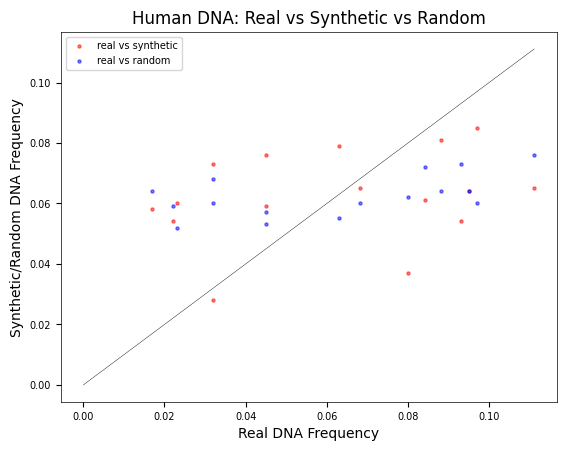

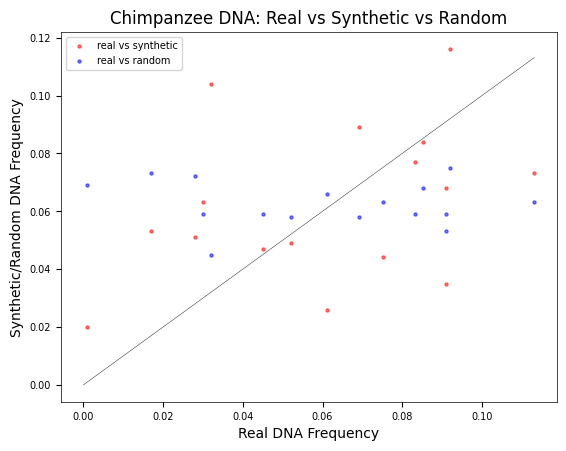

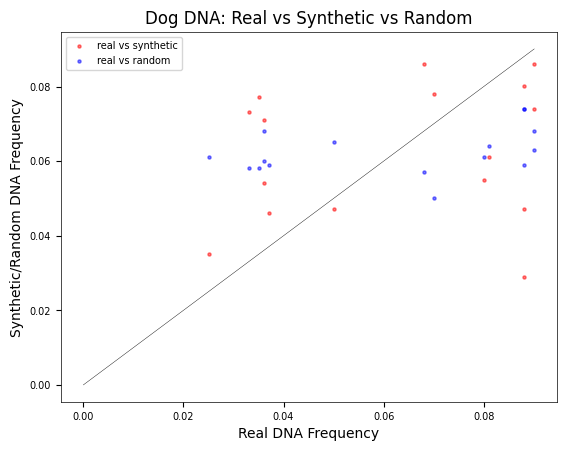

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def compute_pdf(sequence, k=2):
    from collections import Counter
    n = len(sequence)
    k_mers = [sequence[i:i+k] for i in range(n-k+1)]
    k_mer_counts = Counter(k_mers)
    total_k_mers = sum(k_mer_counts.values())
    pdf = {k_mer: count / total_k_mers for k_mer, count in k_mer_counts.items()}
    return pdf

# plot comparison graphs
def plot_comparison(pdf_dna, pdf_synth, pdf_random, species_name):
    mpl.rcParams['axes.linewidth'] = 0.5
    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['ytick.labelsize'] = 7

    min_length = min(len(pdf_dna), len(pdf_synth), len(pdf_random))
    pdf_dna = list(pdf_dna.values())[:min_length]
    pdf_synth = list(pdf_synth.values())[:min_length]
    pdf_random = list(pdf_random.values())[:min_length]

    plt.scatter(pdf_dna, pdf_synth, s=5, color='red', alpha=0.5)
    plt.scatter(pdf_dna, pdf_random, s=5, color='blue', alpha=0.5)
    plt.legend(['real vs synthetic', 'real vs random'], loc='upper left', prop={'size': 7})
    plt.plot([0, np.max(pdf_dna)], [0, np.max(pdf_dna)], c='black', linewidth=0.3)
    plt.xlabel('Real DNA Frequency')
    plt.ylabel('Synthetic/Random DNA Frequency')
    plt.title(f'{species_name} DNA: Real vs Synthetic vs Random')
    plt.show()

#I have copy pasted the values from outputs obtained from previous blocks
sequence_human = "ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCATACTCCTTACACTATTCCTCATCACCCAACTAAAAATATTAAACACAAACTACCACCTACCTCCCTCACCAAAGCCCATAAAAATAAAAAATTATAACAAACCCTGAGAACCAAAATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAGNATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAGGCCTACCCGCCGCAGTACTGATCATTCTATTTCCCCCTCTATTGATCCCCACCTCCAAATATCTCATCAACAACCGACTAATCACCACCCAACAATGACTAATCAAACTAACCTCAAAACAAATGATAACCATACACAACACTAAAGGACGAACCTGATCTCTTATACTAGTATCCTTAATCATTTTTATTGCCACAACTAACCTCCTCGGACTCCTGCCTCACTCATTTACACCAACCACCCAACTATCTATAAACCTAGCCATGGCCATCCCCTTATGAGCGGGCACAGTGATTATAGGCTTTCGCTCTAAGATTAAAAATGCCCTAGCCCACTTCTTACCACAAGGCACACCTACACCCCTTATCCCCATACTAGTTATTATCGAAACCATCAGCCTACTCATTCAACCAATAGCCCTGGCCGTACGCCTAACCGCTAACATTACTGCAGGCCACCTACTCATGCACCTAATTGGAAGCGCCACCCTAGCAATATCAACCATTAACCTTCCCTCTACACTTATCATCTTCACAATTCTAATTCTACTGACTATCCTAGAAATCGCTGTCGCCTTAATCCAAGCCTACGTTTTCACACTTCTAGTAAGCCTCTACCTGCACGACAACACATAANATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTGTTCAGTGTCTGAGTGCTATGAAGATTGCACACAGAGGTCCAGATGCATTCCGTTTTGAGAATGT"
sequence_chimp = "ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCATACTCCTGACACTATTTCTCGTCACCCAACTAAAAATATTAAATTCAAATTACCATCTACCCCCCTCACCAAAACCCATAAAAATAAAAAACTACAATAAACCCTGAGAACCAAAATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAGNATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAGGCTTACCCGCCGCAGTACTAATCATTCTATTCCCCCCTCTACTGGTCCCCACTTCTAAACATCTCATCAACAACCGACTAATTACCACCCAACAATGACTAATTCAACTGACCTCAAAACAAATAATAACTATACACAGCACTAAAGGACGAACCTGATCTCTCATACTAGTATCCTTAATCATTTTTATTACCACAACCAATCTTCTTGGGCTTCTACCCCACTCATTCACACCAACCACCCAACTATCTATAAACCTAGCCATGGCTATCCCCCTATGAGCAGGCGCAGTAGTCATAGGCTTTCGCTTTAAGACTAAAAATGCCCTAGCCCACTTCTTACCGCAAGGCACACCTACACCCCTTATCCCCATACTAGTTATCATCGAAACTATTAGCCTACTCATTCAACCAATAGCCTTAGCCGTACGTCTAACCGCTAACATTACTGCAGGCCACCTACTCATGCACCTAATTGGAAGCGCCACACTAGCATTATCAACTATCAATCTACCCTATGCACTCATTATCTTCACAATTCTAATCCTACTGACTATTCTAGAGATCGCCGTCGCCTTAATCCAAGCCTACGTTTTTACACTTCTAGTGAGCCTCTACCTGCACGACAACACATAANATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGCCGGCGGCGCGGAGCTCCGGGCCCGGCTCCCCAGGCCGTGCGGGACCGTCGGGGCCGAGCGCCGC"
sequence_dog = "ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAATATTTCTCACCCTCTTCATCCTATTTCAACTAAAAATTTCAAATCACTACTACCCAGAAAACCCGATAACCAAATCTGCTAAAATTGCTGGTCAACATAATCCTTGAGAAAACAAATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAANATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAGGTCTCCCTATTGTGGTACTGATCGTCATATTCCCTTCCATTTTATTCCCAACACCCAGTCGCCTAATCAATAATCGGTTAATCTCCATTCAGCAATGACTAATTCAACTAACATCAAAACAAATACTAGCAATTCATAACCAAAAGGGACGAACCTGAGCTCTCATACTTATATCACTAATTCTATTTATTGGCTCAACTAATCTACTTGGACTATTACCTCACTCATTTACGCCCACAACACAACTCTCTATAAACCTCGGAATAGCAATTCCCCTATGAGCAGGGACAGTAATTACCGGTTTCCGCTATAAAACCAAAGCATCCTTAGCACACTTTCTACCCCAAGGCACCCCTCTCCCCCTAATTCCAATACTAGTAGTCATCGAAACTATTAGTCTATTTATTCAACCCATGGCTCTAGCCGTTCGATTAACCGCCAATATTACTGCAGGACACCTCCTAATCCATTTGATTGGAGGGGCTACCTTAGCTCTTATCAATATTAGCGCGACCACAGCTTTTATCACTTTTATTATTCTAATCCTACTTACGATCCTAGAATTTGCTGTTGCCTTAATTCAAGCCTATGTTTTTACCTTACTAGTGAGTCTATACTTACATGACAACACCTAANATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCGGCGGCGTCAGTAGCAGTGGCGGCGGTGGTAGCTTCGCGTCCCCGGGTCGCCTGTTTCCCGGGGCGCC"

synthetic_sequence_human = "TTGTTTTCTTCACCTAAATGCACAAGAATGGTGGGCCGAGGAGCCATGTCAAGTGGGGATGGGTCTATCGAACCTGAGGGCCCCCCACTTCAGATGCTTCGTACTGTCTTTGGGACTTCTCACCGTCTCATGGTCTGCCCTGCCCCGCAGTGTGGCCTGGTATTTTTAACCCTATTATAGAAACAACAATTTATGGGCTCCTTGAAGCTTATACAATACAACAGTAAAGGGCCCCTCCTCCAGTCAGCCTCTTTCCCTCTTAGGGTAAATGAGGATATCCAAGTGCCCACCTCATCATCAACTCCGCCACCAGTTTGCAGCCCTTGCAGGAGATTTCTGGTGATGAAAGTTCAGTGGACTTGGGAAAAGCCGTCATGCTGTCTGCCAACCAAATATACATGACTACATTGTCCCGAGCGAGACCCTGGCAAAAGGCCGCCGCAGCCATACTTTGGCGTGGGGCACTATAGCGGCAGGCATTCAAAAACCTCCAGAGTTTGTTTCCACCAGAACAGTTCAGAGACCACTCCTCGGGAATGGCATCTCCAGGGGGGAGGAAGTATCACATCAGCAGAAGACGCCGCGAGCTCCCCTGGAGTTTTCAGGGCAGAACCGGGTCTTGATGCAGAATCTGAGTCAGCCAAGGTGACATTTTGTATGTGATCAACAGTCTGCTATCGTGTCCAACCACACCAGTACTGACATTCTTCATCGGGCTATGGCAATTACCCTGTGTACAAAGGACTGTGACGCCGTGCTGAGATTCTGACCTGGTGTGTCAAGGTGGTGATAGTGTTTGAAATTAGTCCCATCGTCACCCAGCTGTATGATCTTTCCAGGGGCGTTTTCTCCTGTGGAGGGTATACTGCTTAAGAAGACCAGCCAGCCGAGGAACACAAGGATGGCAGCCACTAGAATGAGCCGAGAGTGAAGCGTCCTGTCTTCAGGAAGGTGACACCAGAAGAACAGCATCCTGGGCAGCCATGGAGACTTTAAGCGG" 
synthetic_sequence_chimp = "TTGTCTGTTATCATTCTATTAAGAAGCAGGCTTTCATCAACCCTCTGGTGGCCTTTAAGAGGAACTCGGTGGCTGCAGGCCGTCCCAGCCTAGCCAGCTCCGCAGGCTTTAACATCGAGAGAACTGCCCTCAAATGCCGAGCAGCATGGCCCCCCACAGCACACCTCACCCAACTAAACCCTGACATGTGCACCAACTATTTGGAACTAAATTACCATCTCATGTTCATTCTACACTACAACCACCAACAATCCACCATCAAAACCCAACAATGAACGACAAATTCCCCAGGTTTCAACCTGGAAGGGAAGGCAGCATGCTGGTGGTGGCCTCGCGGCGGAGCTCTGTTCACCCAACATCTGGTGAAGCATCAACATTACTGCACTCATCAACTGCAGGTGAATTGAAGATCCTTAGCCTTAATAATACCACCCATGAACCACAACAATGAAGCAGCATTTTCAACAATGAAGAGGCCGAGCTCCTGGAGCTCGTCACCACAGCTCCTTATCTACCCTATCCCCAACAATCCTACAATGACTTCACACCATCAAATATCACGACGTCTGATCTCTCATCACAGCATCTCATGCAATAGTAGTGAATGCACGATGATGGGCAAGCAGCACTATCTTCAGAAATAATAAACAACTGTTATCTCTGTTCTTGGAGGCCGCAGGTTTCATTCATTCTACCATGGGACTTGAAAGGGACTTTGGTCCTGAGGAAAATACCCCCATGGTGGCCTTTCTTGTGGCTATGACACCACCCATACTCATCTCTCTCTCTGGGAAGGGAGAACCACCCACCAACAAATGCCCCCCCCCCCCCCCTCTGGTGAAGCATGACCAACCCACCATCTACAACCAACCAACTGACCAACCCACACCTATGAGAAAGGATGGGAACTCGGGCCACCATCTCAGTACGACGCCCCACCCCATGAACTGCTGGTGCACCATCTCAAACTGACCTCAACCGACTTCATCATTCGACAAAT"
synthetic_sequence_dog = "TTGTTTCCACCAGCTGCTCAAGCTACAGGGCACAAAGCAGCCTCACAGCATCCTGGAAGAGACCTCCAGGTGATCTTTTGATAAAGTTGAGATGTGACTGGGGCCAGGAGCGTGTGACTATTTTACAGAACGTCAGATCCCTGTGGACAGGTTTGTCATCAGCGGCCTGCTGGAAAGGATAAGAAACAAGCCTCGTCTGGCAGTGGCCCCCTAATGGCGGTCGGACCGCTGCCTGTTACCAAAATGCAGAGGCCTATGATTGCAGAGAACTTCCATTGAAGGTGTCTCCCTGCCCGCTGCCCAGTGATGATTACCAAGTACAGCAATTACCAACTCCTGGCTGCAGGCACAAGTTGGACAGCCCATGGAGGTTCTGGAGTCGTGAGAATCCTCCGACAAGCGCGTGCTAGGAATATTGGAGAAGGCACATACATGCAAAATGGAGAGCTGGGCGGCGCGCAGCTAGTTTGATTCAGTTACCAACTCCTGTGCAGCCCCCAGCTCCCTCAGATTTCATTCCAGTACTCCTCAGGTGTGGCGTTCAGTAGCTGAGACGACAGATGGTGATGACAAGACAGAACAAAAGGCAAATGTAGCTATGGAGAAGTCATTCTTCAGAGATACTTATCAATGTGTTCCTGTGCTGGTCTCCAGAGTCTTCCCCACGGGAAGAGAAGGCCATGGTCATCCTGGGATCTCTGAGGAGTCCGACTGCACGGTTTCCGGGCAGCCTACGCTGCTTTCCTGGCAAAAAGCGTCTCTACACCAGGGACCCACGGGCCCAGCCGGCTTCTCGCAATATTTCTAGAACTTCGGCCTGCAGAGCTGATCTCTAACCACCCCCTCCTGCCGCCAGGCGGAAAAGGCAGAAGATTGACCTGGCCATCTGTCGAGGACGGGCGCGGGGGGCCGACAATCCCATTGAAGCACACTACAGGTGAGCACACATGCGGGATGCTCCCTGGTGGCCACACAGTTACCTTGCTGGCTCTTCAGCAGC"

random_sequence_human = "TGCGCCACCGTATAATGACATAGGCCTGCATCCTCACACGAGAGAATGCATACATCAGATCTCTGATAGGAAGCCCTACAGCATATATGGCGACCTTGCTCCAGTATTTGCGTAGGTCTTAGGTCTCCCTCTGACTGGCGCTAGTGGACAACACCTCGGGAATTACTAGTTGTTATCAAAAGGTCAAGTGTTGTTGTCAGTTGTAGGATGTTATGTTCTCAACGGGGAGAGTTAATGAACATGGTTCTCATTGCCGTGGTTAAGGCCGCGCTAGCCGAGCTCTAGCAGAGATGGGCTCGTTGTACATCAGCTAAGACAGCACTCCCCCCGACTTGAAAAAGTTATAGGACGCCCACGTATGATTTACCATACCCCTCCCGAGAGTGGTTGTCCTAGTGTGAGGTTGGCCAGTGAGGATTTCGTCGGATCCATCCTCCCACTCACCGAGATTGGGAGACCTGTGAACTTAATTTATTTTTTACAACTTGCCGCTTTAGCTCGTGGTGATCCTGCTCGCGAACTCATGTACTGTCATACCTTGGTGCAATTTCCAGGTGCACCATGGAGCGATAGAGGATGTTTCTGGTATAACAGGTGGCATAAGTTCCTTCAGCAACTCACGCGAAGGCTTGCTCACAAAAGTCCCAAATCAAACCAACCTACCTCTTGGACCCTCGTATCAAGAGCTAGTGTATTGATTGCGTGTGCCCCATAACCGCACACACCCTTTTGGATGGTGGTATTCCTATACCAGGCCCCCTCCGATATGTTCCTCACTTGGTTGCTACGTTGCGGGATTAAGCGTCCGGCGTGTCGTAGGATTGCGGTGCTATTTAGTGAACCCCGTACCACAAATCCGTGTCCCGGCACAAATTATGAGTACAAACGAATGCGCTAGTAAGATCGAAGAGGTTCAGCTTACCGTAAGTAAAGCGTCACTGGCGGGCGACCGGTACGTTAGGATGGCGACGTTCCTTTTCCGAACATGAGCATCTACCCA"
random_sequence_chimp = "ATCGTTACGCACACTGTTTCTGCGGGTTATGATAGAAGCATTCTTATCCGTTACATAATCCGTGAGTACTGTTCTATATCAATTTTATTGACAGCCAGTGAACACCTTGACGGGATGCGCAGACCTGTTCCCGTAAAATGGACCTCGTTTACAAGATGGGTGTCATTCTTGGGAATTCCCTTCACTTTCGCACTACTCAGGGTGTTCGACATGAGCAGGCTGTCACCCGCACGGCAAAATACCCGTCCGTATGACGGGCTCTATCGCGCCCTGATCACCTGCTGTGAGAAACACTGTACCGATTGAGATCCAATGCGTTGCCGCAGCTGGGCTCCCGCGACATCAGCCATTTGGGTTAGATCGCAGCGATATGCCTATCCCTTGATCTAAGCGAGACCTAGGCGTGGGGAGGCAACAGGTTGTCCTAACGTCTAACCTAAGTCTGCTGGTCAATGCCGGTTGTCTTTTCTATTCGCACTAGCTTGCAGATGGAGGCGACGAAAAACTTAAACCGAGGTCGCACACCCGATGCCGCCCAGGTATAGTAGGAGCAGCAGAGCAACCATTTTGGGGTGTCGTCCACTCTGGTCCTGTGACGATATAGCCCGTTGAAGCACCCCCCCGGGGGTATCTCGCAATTCGCGGATCACTTCGATCCGGCCCCATAGGGAAGAATTGTATAGGACACTATTCCTAACAACGCAGTGCACATTGTGCCGCGTCGCACAATTGAAGTCCTTTTGGCGTGGCGGCGCGTCTTGGGAACTAGATTGTCTATTCATATGTGACGCCGTCGCGATTGGCAGTGGAGTGTTCGGCACCTCTATGCAGCCTCATACGCCTTAACACAGGCGTGCTAAGATGGCCACACCGCTGGTGAATCAGGACGGGTGCCCTTAGGTCAATGCGCCTAAGGTAGGAGGGGCACTAGATTGAACAAGAACCTGCATGGGTAGCATCCACGGCATGTTGGTAGTAGCCCTGGAGCCTCGGTGAGCGG"
random_sequence_dog = "TGGCATTAGCTCTTTCCCACTCTAATACGGTGATAGGGCTCACGCATCGCTCGTCGGTACTGTATTCTACCCCGAGCTCTGATGACTATTCCTGAATTGCCTGGACAGATCACTAGCTGGTGAACACTAGGAAAGAGGCTTTGGCGGTGTGGGTTAGCATAAGAGAGCCGCCACCGCAGGCGCGCCGTAGAGGTGAAAGATGTTAAGGTACGAACACGTCCCGCTGTCTTGGTGGTCTGAGTTCTACGTATTCCGATACTAGACAGACTTATTCTGGCTCATTGCAAACTGGGCTGTGGGTTTACGACAGTCTACACCCCCGTGAGACGGGAGTTCGTTCCATTTAATTGTGCCTCTAGCCTATCTAATCGATGTGCTACTCAAGGAACCGGTTGCGCACTTCTGTCTTATGCTGGGTAACGTTGAAACCCCAGACTGTACAAAAACCAGCCAAGGCTTTCTTAGTGCAGGCCTAGATGGAGCACGGCGTCTTTATGTCAGCGGGAGATGGCTTCTCAGTGGACGCTTAGAACTATATAGAAGTTTGTCTCGACGAACTTCATAGAGTATAAACTCCGGCCTGCCACCCTTTGATCGTCGACGTTGACTCCAATCTTACCACAAGCACCCCACTATCATCAAGCCTAAAGCAACGGACTAATCGCCAGCCAAAAGCGGCCAGAGTTCACGCTATCGTGGCTTTCTGCCTGATGGTTTCAGCAGGTCAGGGTAGACTAATATTATATAACAGGGCGCGGTGTACGTCACACAGCCCAAAAGATGGCACCATTACACGATAAATAAACAATACTATACGCTTAGTCTGCCGGCCTTCTCAACGCGAGCGGAAGGTTGTGCAGAGTGACGTTATAACCGCTAACTCGAATTCAGTTGCCTGAAACGAGAACTCGCCAGTTGTACCCAATAACAAAAGGCCCATTGTACTACATGGAAGTTCCCGGTCGCCACGACACCGTAGCCCAGAGGGACTCGAGGACTA"

# Compute PDFs for each sequence
pdf_dna_human = compute_pdf(sequence_human)
pdf_synth_human = compute_pdf(synthetic_sequence_human)
pdf_random_human = compute_pdf(random_sequence_human)

pdf_dna_chimp = compute_pdf(sequence_chimp)
pdf_synth_chimp = compute_pdf(synthetic_sequence_chimp)
pdf_random_chimp = compute_pdf(random_sequence_chimp)

pdf_dna_dog = compute_pdf(sequence_dog)
pdf_synth_dog = compute_pdf(synthetic_sequence_dog)
pdf_random_dog = compute_pdf(random_sequence_dog)

# Call the function for each species
plot_comparison(pdf_dna_human, pdf_synth_human, pdf_random_human, "Human")
plot_comparison(pdf_dna_chimp, pdf_synth_chimp, pdf_random_chimp, "Chimpanzee")
plot_comparison(pdf_dna_dog, pdf_synth_dog, pdf_random_dog, "Dog")


## Analysis of Result

Hellinger Distance Between Real DNA Sequences
Hellinger Distance between real Human DNA and real Chimpanzee DNA: 0.0217

This low value indicates that the real DNA sequences of humans and chimpanzees are very similar. Since humans and chimpanzees share a recent common ancestor and a significant portion of their genomes, this result is expected.
Hellinger Distance between real Human DNA and real Dog DNA: 0.0367

This value, while still relatively low, is higher than the distance between human and chimpanzee DNA. This indicates that the real DNA sequences of humans and dogs are less similar compared to those of humans and chimpanzees. This makes sense because humans and dogs are more distantly related.
Hellinger Distance Between Synthetic DNA Sequences
Hellinger Distance between synthetic Human DNA and synthetic Chimpanzee DNA: 0.0162

This even lower value suggests that the synthetic DNA sequences generated for humans and chimpanzees are very similar. The synthetic process may have captured and amplified the similarities in the original datasets.
Hellinger Distance between synthetic Human DNA and synthetic Dog DNA: 0.0161

This value is similar to the synthetic human-chimpanzee distance. This might indicate that the synthetic sequences are somewhat homogenized, reflecting the general patterns in the training data rather than species-specific nuances.
Comparison and Interpretation
Real Human vs. Real Chimpanzee DNA (0.0217) vs. Real Human vs. Real Dog DNA (0.0367):

The real DNA of humans and chimpanzees is more similar to each other than to that of dogs. This aligns with the evolutionary relationship where humans and chimpanzees share a more recent common ancestor.
Synthetic Human vs. Synthetic Chimpanzee DNA (0.0162) vs. Synthetic Human vs. Synthetic Dog DNA (0.0161):

The synthetic DNA sequences show very low Hellinger distances, suggesting high similarity. This might be due to the synthetic sequence generation process capturing broad patterns across species rather than finer species-specific details. The similarity between synthetic human and chimpanzee DNA, and synthetic human and dog DNA being nearly identical, indicates that the synthetic method may not be distinguishing the unique characteristics of each species' DNA as effectively.
Conclusions
Real DNA Comparison:

The real DNA sequence comparison reflects expected biological relationships, with humans being closer to chimpanzees than to dogs.
Synthetic DNA Comparison:

The synthetic DNA sequences are highly similar to each other, regardless of species. This suggests that the synthetic generation process is not fully capturing species-specific DNA characteristics, likely due to the constraints or simplifications in the synthetic model.
Recommendations
Improving Synthetic DNA Generation:
To improve the synthetic DNA generation, consider refining the model to better capture species-specific characteristics. This might involve incorporating more detailed biological constraints or using a more sophisticated synthesis algorithm.
Further Analysis:
Conduct additional analysis to understand the specific patterns and features that the synthetic DNA sequences are capturing. This can help in fine-tuning the synthetic process to better differentiate between species.

### Application

**Multi-Species Analysis:** By applying the model to multiple species (Human, Chimpanzee, and Dog), the project explores the versatility and robustness of LLM techniques in synthesizing realistic genomic sequences across different species. This can be further extended to other species as well.<br>

**Molecule Synthesis:** The approach can be extended to other applications, such as molecule synthesis, by treating sequences of symbols (representing molecular structures) in a similar statistical framework.

## Conclusion

In this project, we are using LLM techniques to synthesize realistic DNA sequences by learning the statistical patterns from real DNA data. The synthesis process is akin to generating text with language models, where next segment is predicted based on the previous segment's context. <br>

The quality of the synthesized sequences is evaluated using Hellinger distance, ensuring that the synthetic sequences closely mimic the patterns found in real DNA. The approach can be extended to other applications, such as molecule synthesis, by treating sequences of symbols in a similar statistical framework. 